In [ ]:
! pip3 install langgraph langsmith langchain langchain-community arxiv wikipedia langchain-openai

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
import langchain_community

In [2]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

### Arxiv and wikipedia tools

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tools = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tools = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [74]:
print(
    wiki_tools.run("unsupervised learning")
)  # wiki_tools.run("explain me the theory of relativity in brief")

Page: Unsupervised learning
Summary: Unsupervised learning is a framework in machine learning where, in contrast to supervised learning, algorithms learn patterns exclusively from unlabeled data. Other frameworks in the spectrum of supervisions include weak- or semi-supervision, where a small portio


In [4]:
print(
    arxiv_tools.run(
        "explain me the latest research papers on quantum computing in brief"
    )
)  # arxiv_tools.run("explain me the latest research papers on quantum computing in brief")

Published: 2025-04-07
Title: Quantum Computing: Vision and Challenges
Authors: Sukhpal Singh Gill, Oktay Cetinkaya, Stefano Marrone, Daniel Claudino, David Haunschild, Leon Schlote, Huaming Wu, Carlo Ottaviani, Xiaoyuan Liu, Sree Pragna Machupalli, Kamalpreet Kaur, Priyansh Arora, Ji Liu, Ahmed Faro


In [64]:
tools = [wiki_tools, arxiv_tools]
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [65]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(state_schema=State)

In [38]:
import openai
from dotenv import load_dotenv

load_dotenv(".env")
import os

openai_client = openai.OpenAI(
    api_key=os.getenv("OPENAI_API_TOKEN"), base_url=os.getenv("OPENAI_API_BASE")
)
client = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "what is the capital of india and who is the prime minister of india, give full name of the prime minister?",
        }
    ],
    model="gpt-4o",
    temperature=0.5,
)

print(client.choices[0].message.content)

The capital of India is New Delhi. As of my last update, the Prime Minister of India is Narendra Modi, whose full name is Narendra Damodardas Modi.


In [39]:
from langchain_openai import ChatOpenAI

openai_llm_model = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    api_key=os.getenv("OPENAI_API_TOKEN"),
    base_url=os.getenv("OPENAI_API_BASE"),
)
openai_llm_model.invoke(
    "what is the capital of india and who is the prime minister of india, give full name of the prime minister?"
).content

'The capital of India is New Delhi. As of my last update, the Prime Minister of India is Narendra Modi, whose full name is Narendra Damodardas Modi.'

In [66]:
llm_openai_with_tools = openai_llm_model.bind_tools(tools)

In [67]:
def chatbot(state: State):
    # return {"messages": [llm_openai_with_tools.invoke(state["messages"])]}
    response = llm_openai_with_tools.invoke(state["messages"])
    print(f"Response : {response}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 Tool calls requested: {[tc['name'] for tc in response.tool_calls]}")
    else:
        print("💬 LLM responding directly (no tools)")
    return {"messages": [response]}

In [68]:
from langgraph.prebuilt import ToolNode, tools_condition

In [69]:
# this will create a chatbot node which will use llm with tools
graph_builder.add_node("chatbot", chatbot)
# adding edges from start to chatbot node
graph_builder.add_edge(START, "chatbot")
# crate a tool node
tool_node = ToolNode(tools=tools)
# add tool node to the graph
graph_builder.add_node("tools", tool_node)
# add conditional edges from chatbot to tools node based on tools_condition
graph_builder.add_conditional_edges("chatbot", tools_condition)
# add edge from tools node to chatbot node
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [70]:
graph = graph_builder.compile()

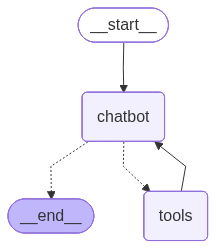

In [71]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid PNG rendering not supported in this environment.")

In [73]:
user_input = "unsupervided Learning"
events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

unsupervided Learning
Response : content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 158, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-CrycZH8WRVigX8WzbtUEMLsaXaAeO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019b683d-e809-7d32-9a8c-329d370e0113-0' tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Unsupervised Learning'}, 'id': 'call_NHoNV5pAH9WfnKSJxY5BgDUL', 'type': 'tool_call'}, {'name': 'arxiv', 'args': {'query': 'Unsupervised Learning'}, 'id': 'call_b1GgomryXNwBFSFaW9wYVaIL', 'type': 'to

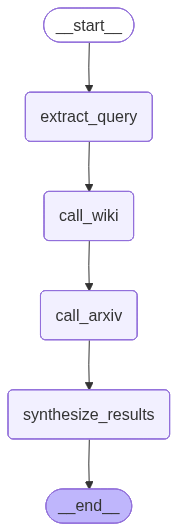

Testing Sequential Flow: Wikipedia → Arxiv → Synthesis
Extracting user query...
[HumanMessage(content='unsupervised Learning with domain adaptation techniques', additional_kwargs={}, response_metadata={}, id='634a32b1-16c7-453f-a9ae-ae92e42dbfc0')]
Calling Wikipedia tool...
Calling Arxiv tool...

🤖 Synthesizing results...
✅ Synthesis Complete!

FINAL RESULT:
Unsupervised learning with domain adaptation techniques is a specialized area within machine learning that focuses on improving the performance of models when they are applied to new, but related, data distributions. This is particularly useful in scenarios where labeled data in the target domain is scarce or unavailable, which is a common challenge in real-world applications.

### Domain Adaptation Overview
**Source: Wikipedia**

Domain adaptation is a subset of transfer learning. It involves training a model on a source domain with a certain data distribution and then adapting it to work effectively on a target domain with a diff

In [83]:
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated


class SequenceState(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str  # store the original user query
    wiki_result: str  # store wikipedia result
    arxiv_result: str  # store arxiv result


def extraxt_query(state: SequenceState) -> dict:
    """extract the user query from the messages"""
    print("Extracting user query...")
    print(state["messages"])
    last_message = state["messages"][-1].content
    return {"user_query": last_message}


def call_wiki(state: SequenceState) -> dict:
    """call wikipedia tool and store the result"""
    print("Calling Wikipedia tool...")
    try:
        result = wiki_tools.run(state["user_query"])
    except Exception as e:
        result = f"Error calling Wikipedia tool: {e}"
    return {"wiki_result": result}


def call_arxiv(state: SequenceState) -> dict:
    """call arxiv tool and store the result"""
    print("Calling Arxiv tool...")
    try:
        result = arxiv_tools.run(state["user_query"])
    except Exception as e:
        result = f"Error calling Arxiv tool: {e}"
    return {"arxiv_result": result}


def synthesize_results(state: SequenceState):
    """LLM synthesizes both Wikipedia and Arxiv results"""
    print(f"\n🤖 Synthesizing results...")

    synthesis_prompt = f"""Based on the following information from Wikipedia and Arxiv, provide a comprehensive answer about: {state['user_query']}

Wikipedia Information:
{state['wiki_result']}

Arxiv Research:
{state['arxiv_result']}
If wikipedia and arxiv results are not relevant then use your own knowledge to answer the query and mentioned that in the answer source of information like which wikipedia, arxiv or own knowledge. Mentioned which information is from which source.
Please synthesize this information into a clear, comprehensive response."""

    response = openai_llm_model.invoke(synthesis_prompt)
    print(f"✅ Synthesis Complete!")

    return {"messages": [("assistant", response.content)]}


# create the new graph builder for sequence state
graph_builder_seq = StateGraph(state_schema=SequenceState)
# node for extracting user query
graph_builder_seq.add_node("extract_query", extraxt_query)
# node for calling wikipedia
graph_builder_seq.add_node("call_wiki", call_wiki)
# node for calling arxiv
graph_builder_seq.add_node("call_arxiv", call_arxiv)
# node for synthesizing results
graph_builder_seq.add_node("synthesize_results", synthesize_results)
# adding edges
graph_builder_seq.add_edge(START, "extract_query")
graph_builder_seq.add_edge("extract_query", "call_wiki")
graph_builder_seq.add_edge("call_wiki", "call_arxiv")
graph_builder_seq.add_edge("call_arxiv", "synthesize_results")
graph_builder_seq.add_edge("synthesize_results", END)
# compile the graph
graph_seq = graph_builder_seq.compile()
# visualize the graph
try:
    display(Image(graph_seq.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid PNG rendering not supported in this environment.")

# Step 4: Test it!
print("=" * 60)
print("Testing Sequential Flow: Wikipedia → Arxiv → Synthesis")
print("=" * 60)

user_input = "unsupervised Learning with domain adaptation techniques"
result = graph_seq.invoke({"messages": [("user", user_input)]})

print("\n" + "=" * 60)
print("FINAL RESULT:")
print("=" * 60)
print(result["messages"][-1].content)

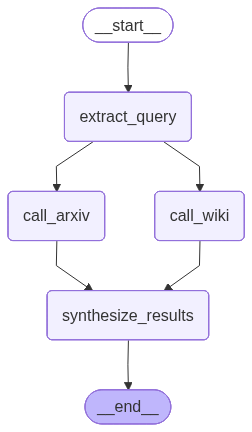

Testing Parallel Flow: Wikipedia + Arxiv → Synthesis
Extracting user query...
[HumanMessage(content='unsupervised Learning', additional_kwargs={}, response_metadata={}, id='e8ba45d4-15b4-48ae-bc22-d90d3be88b96')]
Calling Arxiv tool...
Calling Wikipedia tool...

🤖 Synthesizing results...
✅ Synthesis Complete!

FINAL RESULT:
Unsupervised learning is a machine learning paradigm where algorithms are designed to identify patterns and structures in data without the guidance of labeled outcomes. Unlike supervised learning, which relies on labeled datasets to train models, unsupervised learning works with data that has no explicit labels or annotations. This approach is particularly useful for tasks where labeling data is impractical or impossible.

**Key Concepts of Unsupervised Learning:**

1. **Clustering:** One of the primary applications of unsupervised learning is clustering, where the algorithm groups similar data points together. Common clustering algorithms include K-means, hierarchic

In [ ]:
from langgraph.graph import StateGraph, START, END

parallel_graph_builder = StateGraph(state_schema=SequenceState)
parallel_graph_builder.add_node("extract_query", extraxt_query)
parallel_graph_builder.add_node("call_wiki", call_wiki)
parallel_graph_builder.add_node("call_arxiv", call_arxiv)
parallel_graph_builder.add_node("synthesize_results", synthesize_results)
parallel_graph_builder.add_edge(START, "extract_query")
parallel_graph_builder.add_edge("extract_query", "call_wiki")
parallel_graph_builder.add_edge("extract_query", "call_arxiv")
parallel_graph_builder.add_edge("call_wiki", "synthesize_results")
parallel_graph_builder.add_edge("call_arxiv", "synthesize_results")
parallel_graph_builder.add_edge("synthesize_results", END)
parallel_graph = parallel_graph_builder.compile()
try:
    display(Image(parallel_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid PNG rendering not supported in this environment.")
# Step 5: Test it!
print("=" * 60)
print("Testing Parallel Flow: Wikipedia + Arxiv → Synthesis")
print("=" * 60)

user_input = "unsupervised Learning"
result = parallel_graph.invoke({"messages": [("user", user_input)]})

print("\n" + "=" * 60)
print("FINAL RESULT:")
print("=" * 60)
print(result["messages"][-1].content)

In [ ]:
import time

# Test Sequential vs Parallel
print("=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

# Sequential Graph
print("\n🐢 Testing Sequential Graph (Wikipedia → Arxiv → Synthesize)...")
start = time.time()
result_seq = graph_seq.invoke({"messages": [("user", "machine learning")]})
seq_time = time.time() - start
print(f"⏱️  Sequential Time: {seq_time:.2f} seconds")

print("\n" + "-" * 60)

# Parallel Graph
print("\n🚀 Testing Parallel Graph (Wikipedia + Arxiv || → Synthesize)...")
start = time.time()
result_parallel = parallel_graph.invoke({"messages": [("user", "machine learning")]})
parallel_time = time.time() - start
print(f"⏱️  Parallel Time: {parallel_time:.2f} seconds")

print("\n" + "=" * 60)
print(f"⚡ Speed Improvement: {seq_time - parallel_time:.2f} seconds faster")
print(
    f"📊 Performance Gain: {((seq_time - parallel_time) / seq_time * 100):.1f}% faster"
)
print("=" * 60)

PERFORMANCE COMPARISON

🐢 Testing Sequential Graph (Wikipedia → Arxiv → Synthesize)...
Extracting user query...
[HumanMessage(content='machine learning', additional_kwargs={}, response_metadata={}, id='f5aa8155-97a2-442b-962f-eeca4f6896e2')]
Calling Wikipedia tool...
Calling Arxiv tool...

🤖 Synthesizing results...
✅ Synthesis Complete!
⏱️  Sequential Time: 10.45 seconds

------------------------------------------------------------

🚀 Testing Parallel Graph (Wikipedia + Arxiv || → Synthesize)...
Extracting user query...
[HumanMessage(content='machine learning', additional_kwargs={}, response_metadata={}, id='d86293cb-bbef-463d-b9e0-a08ee6907ca2')]
Calling Arxiv tool...
Calling Wikipedia tool...

🤖 Synthesizing results...
✅ Synthesis Complete!
⏱️  Parallel Time: 7.26 seconds

⚡ Speed Improvement: 3.19 seconds faster
📊 Performance Gain: 30.6% faster
